## Data Set Information:
[UCI source](http://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+temperature+modulation)  
[Data folder](http://archive.ics.uci.edu/ml/machine-learning-databases/00487/)

A chemical detection platform composed of **14 temperature-modulated metal oxide semiconductor (MOX) gas sensors** was exposed to dynamic mixtures of carbon monoxide (**CO**) and humid synthetic air in a gas chamber.

The acquired **time series of the sensors** and the measured values of **CO concentration**, **humidity** and **temperature** inside the gas chamber are provided.

- **Chemical detection platform**  
The chemical detection platform was composed of **14 MOX gas sensors** that generate a time-dependent multivariate response to the different gas stimuli.
The utilized sensors were made commercially available by Figaro Engineering (**7** units of **TGS 3870-A04**) and FIS (**7** units of **SB-500-12**).
The operating temperature of the sensors was controlled by the built-in heater, which voltage was modulated in the range **0.2-0.9** V in cycles of **20** and **25** s, following the manufacturer recommendations (**0.9** V for **5** s, **0.2** V for **20** s, **0.9** V for **5** s, **0.2** V for **25** s, ...).
The sensors were **pre-heated for one week** before starting the experiments.
The MOX read-out circuits consisted of voltage dividers with **1** MOhm load resistors and powered at **5** V.
The output voltage of the sensors was sampled at **3.5 Hz** using an **Agilent HP34970A/34901A DAQ** configured at **15** bits of precision and input impedance greater than **10** GOhm.

- **Generator of dynamic gas mixtures**  
Dynamic mixtures of CO and humid synthetic air were delivered from high purity gases in cylinders to a small-sized polytetrafluoroethylene (**PTFE**) test chamber (**250** cm<sup>3</sup> internal volume), by means of a piping system and mass flow controllers (**MFCs**).
Gas mixing was performed using mass flow controllers (**MFC**),which controlled three different gas streams (**CO**, **wet air** and **dry air**). These streams were delivered from high quality pressurized gases in cylinders.
The selected MFCs (**EL-FLOW Select, Bronkhorst**) had full scale flow rates of **1000** mL/min for the dry and wet air streams and **3** mL/min for the CO channel.
The CO bottle contained **1600** ppm of CO diluted in synthetic air with **21 &plusmn; 1%** O<sub>2</sub>.
The relative uncertainty in the generated **CO concentration** was below **5.5%.**
The wet and dry air streams were both delivered from a synthetic air bottle with **99.995%** purity and **21 &plusmn; 1%** O<sub>2</sub>.
Humidification of the wet stream was based on the saturation method using a glass bubbler (**Drechsler** bottles).

- **Temperature/humidity values**  
A temperature/humidity sensor (**SHT75**, from **Sensirion**) provided reference humidity and temperature values inside the test chamber with tolerance below **1.8%** r.h. and **0.5** &deg;C, respectively, every **5** s.
The temperature variations inside the gas chamber, for each experiment, were below **3** &deg;C.

- **Experimental protocol**  
Each experiment consisted on **100** measurements: **10** experimental concentrations uniformly distributed in the range **0-20** ppm and **10** replicates per concentration.
Each replicate had a relative humidity randomly chosen from a uniform distribution between **15%** and **75%** r.h.
At the beginning of each experiment, the gas chamber was cleaned for **15** min using a stream of synthetic air at a flow rate of **240** mL/min.
After that, the gas mixtures were released in random order at a constant flow rate of **240** mL/min for **15** min each.
A single experiment lasted **25** hours (100 samples x 15 minutes/sample) and was replicated on **13** working days spanning a natural period of **17** days.

#### Attribute Information:

The dataset is presented in 13 text files, where each file corresponds to a different measurement day. The filenames indicate the **timestamp (yyyymmdd_HHMMSS)** of the start of the measurements.
Each file includes the acquired time series, presented in 20 columns: 

| Time (s)  | CO concentration (ppm)    | Humidity (%r.h.)  | Temperature (C) | Flow rate (mL/min) |  Heater voltage (V) |
| --------- |:-------------------------:|:-----------------:|:---------------:|:------------------:|:-------------------:|

and the measured resistance of the 14 MOX gas sensors: 

| R01 (MOhm) | R02 (MOhm) | R03 (MOhm) | R04 (MOhm) | R05 (MOhm) | R06 (MOhm) |  R07 (MOhm) |
| ---------- | ---------- | ---------- | ---------- | ---------- | ---------- |  ---------- |


| R08 (MOhm) | R09 (MOhm) | R10 (MOhm) | R11 (MOhm) | R12 (MOhm) | R13 (MOhm) | R14 (MOhm) |
| ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- |

Resistance values **R01-R07** correspond to **FIGARO TGS 3870 A-04** sensors, whereas **R08-R14** correspond to **FIS SB-500-12** units.
The time series are sampled at **3.5 Hz**.

**Aquisition module**
  - Agilent HP34970A/34901A DAQ

**Sensors used**
- Sensirion **SHT75**
- FIS **SB-500-12**
- Figaro **TGS 3870-A04**

**Important limitations to note:**
-  MOX sensors lacks selectivity
-  MOX sensors lacks stability
-  MOX sensors have slow recovery time
-  MOX sensors have large tolerances in specifications for identical devices

**Transduction**  
The transduction mechanism of MOX sensors consists on  
measuring resistance changes resulting from chemical interactions  
between the gas species and the metal oxide surface.

**Selectivity**  
Selectivity to a given analyte can be increased by  
modulating the operating temperature with a periodic heating  
power waveform [4]. The resulting multivariate response patterns  
capture the selectivity-temperature dependence characteristic of  
the target gas plus the effect of the interferences. The variables of  
the response pattern are highly correlated because the shape of the  
heating waveform smoothly varies the sensor temperature (except  
for the temperature transitions).

![Block diagram of the LOD estimation/validation method](images/lod-estimation.jpg "Figure 1")  
**Figure 1.** Experimental test bench for the generation of dynamic gas mixtures and acquisition of the sensor signals. Left: Block diagram. Right: Picture. [1]

![Block diagram of the LOD estimation/validation method](images/sensor.png "Figure 2")  
**Figure 2.** Sensor response illustration. [2]

### Exposure due to human inhaling

| Level of CO | Health Effects, and Other Information |
| -----------:|:------------------------------------- |
| 0 PPM | Normal, fresh air. |
| 9 PPM | Maximum recommended indoor CO level (ASHRAE). |
| 10-24 PPM | Possible health effects with long-term exposure. |
| 25 PPM | Max TWA Exposure for 8 hour work-day (ACGIH). Pocket CO TWA warning sounds each hour. |
| 50 PPM | Maximum permissible exposure in workplace (OSHA).First Pocket CO ALARM starts (optional, every 20 seconds). |
| 100 PPM | Slight headache after 1-2 hours. |
| 125 PPM | Second Pocket CO ALARM starts (every 10 seconds). |
| 200 PPM | Dizziness, naseau, fagitue, headache after 2-3 hours of exposure. |
| 400 PPM | Headache and nausea after 1-2 hours of exposure. Life threatening in 3 hours. Third Pocket CO ALARM starts (every 5 seconds). |
| 800 PPM | Headache, nausea, and dizziness after 45 minutes; collapse and unconsciousness after 1 hour of exposure. Death within 2-3 hours. |
| 1000 PPM | Loss of consciousness after 1 hour of exposure. |
| 1600 PPM | Headache, nausea, and dizziness after 20 minutes of exposure. Death within 1-2 hours. |
| 3200 PPM | Headache, nausea, and dizziness after 5-10 minutes; collapse and unconsciousness after 30 minutes of exposure. Death within 1 hour. |
| 6400 PPM | Death within 30 minutes. |
| 12,800 PPM | Immediate physiological effects, unconsciousness. Death within 1-3 minutes of exposure. |


### Analytics approaches suggestion
  1. Threshhold classifier (warning system)
  2. Concentration predictor (advanced logging system)
  3. Concentration classifier (simple logging system)
  4. Substance identifier (monitoring system)

#### Reverences:

The description of the experimental setup and chemical detection platform can be found in [1-2].  
The dataset has been used also in [3].

1. J. Burgués, J.M Jiménez-Soto, S. Marco, *Estimation of the limit of detection in semiconductor gas sensors through linearized calibration models*, Analytica chimica acta 1013 (2018): 13-25.
2. J. Burgués, S. Marco, *Multivariate estimation of the limit of detection by orthogonal partial least squares in temperature-modulated MOX sensors*, Analytica chimica acta 1019 (2018): 49-64.
3. L. Fernandez, J. Yan, J. Fonollosa, J. Burgués, A. Gutierrez, S. Marco, *A practical method to estimate the resolving power of a chemical sensor array: application to feature selection*, Frontiers in chemistry 6 (2018).
30. A.P. Lee, B.J. *Reedy, Temperature modulation in semiconductor gas sensing*, Sensors Actuators B Chem. 60 (1999) 35e42.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensordata
sns.set_style(style='whitegrid')

datasets, features_sets, target_sets, metadata = sensordata.load_and_preprocess_data(validationset=True, savecsv=True, sensorset='ALL')
calibrationset = datasets[0]
calibration_features_matrix = features_sets[0]
calibration_co_cons = target_sets[0]
cal_experiment_matrix, cal_targets = sensordata.postprocess_data(calibration_features_matrix, calibration_co_cons)

/home/dreuter/Github/kaggle-paths/gas-sensor-array/data/gas-sensor-data.zip
already exists, file not downloaded
csv files already exists in
/home/dreuter/Github/kaggle-paths/gas-sensor-array/data,
no files extracted
Starting to import and preprocess sensor data from 20160930_203718.csv
The shape of features matrix is:
(4040, 481)
20160930_203718.csv successfully imported
Starting to import and preprocess sensor data from 20161001_231809.csv
The shape of features matrix is:
(4040, 481)
20161001_231809.csv successfully imported
Starting to import and preprocess sensor data from 20161003_085624.csv
The shape of features matrix is:
(4043, 481)
20161003_085624.csv successfully imported
Starting to import and preprocess sensor data from 20161004_104124.csv
The shape of features matrix is:
(4040, 481)
20161004_104124.csv successfully imported
Starting to import and preprocess sensor data from 20161005_140846.csv
The shape of features matrix is:
(4040, 481)
20161005_140846.csv successfully imp

### Preparing data

In [35]:
obs = 0
dim = features_sets[0].shape[1]
for set in features_sets:
    obs+=set.shape[0]
features = np.zeros((obs,dim))
target = np.zeros((obs,1))
i = 0
end_obs = 0

for set in range(len(features_sets)):
    start_obs = end_obs
    end_obs += features_sets[set].shape[0]
    features[start_obs:end_obs,:] = features_sets[set]
    target[start_obs:end_obs,:] = target_sets[set]

target = target.reshape(len(target))

features = np.array(pd.DataFrame(features).interpolate(axis=1))
features = np.array(pd.DataFrame(features).interpolate(axis=0))
print(features.shape)
print(target.shape)

data = target
test_ratio = 0.2
shuffled_indices = np.random.permutation(len(data))
test_set_size = int(len(data) * test_ratio)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

X_train = features[train_indices]
X_test = features[test_indices]
y_train = target[train_indices]
y_test = target[test_indices]

(52526, 481)
(52526,)


In [23]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20992, 378) (20992,)
(5248, 378) (5248,)


In [ ]:
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=16)
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10,
                                n_jobs=16)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=16)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=16,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [31]:
predictions = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.850732598087045

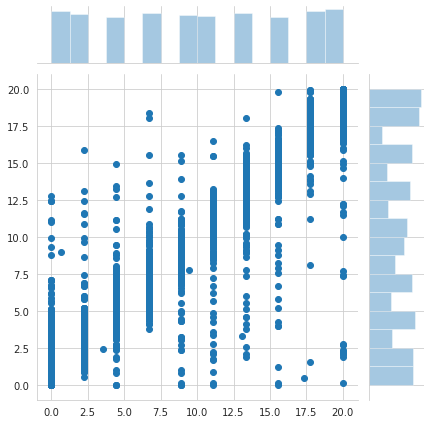

In [32]:
sns.jointplot(y_test, predictions)
plt.show()

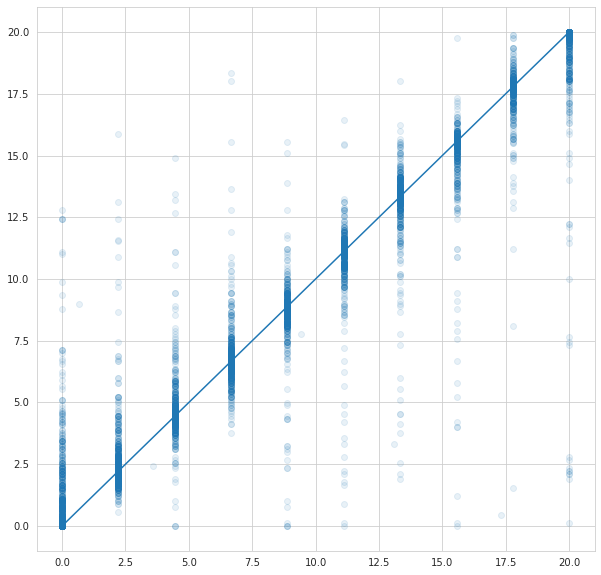

In [33]:
x = y_test
y = predictions.reshape(len(predictions))
plt.figure(figsize=(10,10))
plt.scatter(x,y,alpha=0.1)
plt.plot(np.arange(0,21),np.arange(0,21))
plt.show()

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [3.31147218 2.91752976 3.07508386 3.11156829 3.0274129  3.0362428
 2.97228482 3.20310832 3.18102999 3.08836038]
Mean: 3.0924093294185253
Standard deviation: 0.11007816866725904


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10,
                         n_jobs=16)

tree_rmse_scores = np.sqrt(-scores)

In [27]:
from sklearn.metrics import mean_squared_error

predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.4590868518662443